# Famous People - MLP Neurons

## Setup

In [47]:
import pandas as pd
from easy_transformer import EasyTransformer, utils, ActivationCache
import torch
from typing import List
import numpy as np
from torchtyping import TensorType as TT
from fancy_einsum import einsum
import plotly.express as px

In [45]:
# Plotting helpers
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

## Dataset

https://medialab.github.io/bhht-datascape/

In [2]:
# Pandas display config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# Load data
data = pd.read_csv('cross-verified-database.csv', encoding = "ISO-8859-1")

# Sort by most popular
data.sort_values(by=['wiki_readers_2015_2018'], inplace=True, ascending=False) # Could also total_noccur_links_b

data.head()

,wikidata_code,birth,death,approx_birth,approx_death,birth_min,birth_max,death_min,death_max,gender,level1_main_occ,name,un_subregion,birth_estimation,death_estimation,bigperiod_birth_graph_b,bigperiod_death_graph_b,curid,level2_main_occ,freq_main_occ,freq_second_occ,level2_second_occ,level3_main_occ,bigperiod_birth,bigperiod_death,wiki_readers_2015_2018,non_missing_score,total_count_words_b,number_wiki_editions,total_noccur_links_b,sum_visib_ln_5criteria,ranking_visib_5criteria,all_geography_groups,string_citizenship_raw_d,citizenship_1_b,citizenship_2_b,list_areas_of_rattach,area1_of_rattachment,area2_of_rattachment,list_wikipedia_editions,un_region,group_wikipedia_editions,bplo1,dplo1,bpla1,dpla1,pantheon_1,level3_all_occ
551361,Q22686,1946.0,NaN,NaN,NaN,1946.0,1946.0,NaN,NaN,Male,Leadership,Donald_Trump,Northern America,1946.0,2023.9858,5.Contemporary period 1901-2019AD,5.Contemporary period 1901-2019AD,4848272,Corporate/Executive/Business (large),0.339623,0.283019,Culture-core,magnate,5.Contemporary period 1901-2020AD,Missing,218433920,3,326128,198,96,41.765057,2.0,US,'US',US,NaN,D:_'US'_matchB1_P:_'US',US,Missing,enwiki|dewiki|frwiki|eswiki|ruwiki|itwiki|jawi...,America,grA,-73.816200,NaN,40.700300,NaN,1,D:_magnate_investor_restaurateur_writer_entrep...
79099,Q11571,1985.0,NaN,NaN,NaN,1985.0,1985.0,NaN,NaN,Male,Sports/Games,Cristiano_Ronaldo,Southern Europe,1985.0,2062.0117,5.Contemporary period 1901-2019AD,5.Contemporary period 1901-2019AD,623737,Sports/Games,0.772727,NaN,Missing,football,5.Contemporary period 1901-2020AD,Missing,133777256,3,279612,124,50,40.012989,182.0,Portugal,'Portugal',Portugal,NaN,D:_'Portugal'_matchB1_P:_'Portugal',Portugal,Missing,enwiki|dewiki|frwiki|eswiki|ruwiki|itwiki|jawi...,Europe,grA,-16.916667,NaN,32.650000,NaN,1,D:_football_entrepreneur_model_P:_football_for...
1176328,Q9682,1926.0,NaN,NaN,NaN,1926.0,1926.0,NaN,NaN,Female,Leadership,Elizabeth_II,Western Europe,1926.0,1995.8187,5.Contemporary period 1901-2019AD,5.Contemporary period 1901-2019AD,12153654,Nobility,0.764706,NaN,Missing,monarch,5.Contemporary period 1901-2020AD,Missing,120070856,3,175734,162,41,39.511745,419.0,United_Kingdom_of_Great_Britain_and_Northern_I...,'United_Kingdom',United_Kingdom,NaN,D:_'United_Kingdom'_mismatchB2_P:_'England'_'A...,United_Kingdom,Missing,enwiki|dewiki|frwiki|ruwiki|itwiki|jawiki|nlwi...,Europe,grA,-0.147431,NaN,51.508756,NaN,1,D:_monarch_P:_ queen_English_monarque_royaume_...
16124,Q187447,1949.0,1993.0,NaN,NaN,1949.0,1949.0,1993.0,1993.0,Male,Other,Pablo_Escobar,South America,1949.0,1993.0000,5.Contemporary period 1901-2019AD,5.Contemporary period 1901-2019AD,161570,Other,0.375000,0.250000,Nobility,terrorist,5.Contemporary period 1901-2020AD,5.Contemporary period 1901-2020AD,101129960,3,67702,80,22,37.084747,4043.0,Colombia,'Colombia',Colombia,NaN,D:_'Colombia'_matchB1_P:_'Colombia',Colombia,Missing,enwiki|dewiki|frwiki|eswiki|ruwiki|itwiki|jawi...,America,grA,-75.374167,-75.574828,6.153333,6.244747,1,D:_lord_politician_entrepreneur_P:_ lord_terro...
270124,Q615,1987.0,NaN,NaN,NaN,1987.0,1987.0,NaN,NaN,Male,Sports/Games,Lionel_Messi,South America,1987.0,2065.1382,5.Contemporary period 1901-2019AD,5.Contemporary period 1901-2019AD,2150841,Sports/Games,0.937500,NaN,Missing,football,5.Contemporary period 1901-2020AD,Missing,100513392,3,312419,134,59,40.077526,88.0,"Argentina,Spain",'Argentina'_'Spain',Argentina,Spain,D:_'Argentina'_'Spain'_matchB1B2_P:_'Argentina...,Argentina,Spain,enwiki|dewiki|frwiki|eswiki|ruwiki|itwiki|jawi...,America,grA,-60.650000,NaN,-32.950000,NaN,1,D:_football_P:_football_forward_player_English...


## Compare performance of models

In [3]:
# Load models
solu_model = EasyTransformer.from_pretrained(
    "NeelNanda/SoLU_1L512W_C4_Code",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

attn_model = EasyTransformer.from_pretrained(
    "NeelNanda/Attn_Only_1L512W_C4_Code",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
    )

Loading model: NeelNanda/SoLU_1L512W_C4_Code
Moving model to device:  cuda
Finished loading pretrained model NeelNanda/SoLU_1L512W_C4_Code into EasyTransformer!
Loading model: NeelNanda/Attn_Only_1L512W_C4_Code
Moving model to device:  cuda
Finished loading pretrained model NeelNanda/Attn_Only_1L512W_C4_Code into EasyTransformer!


<AxesSubplot: title={'center': 'Number of tokens vs. difference in probability'}, xlabel='number_tokens', ylabel='diff_prob'>

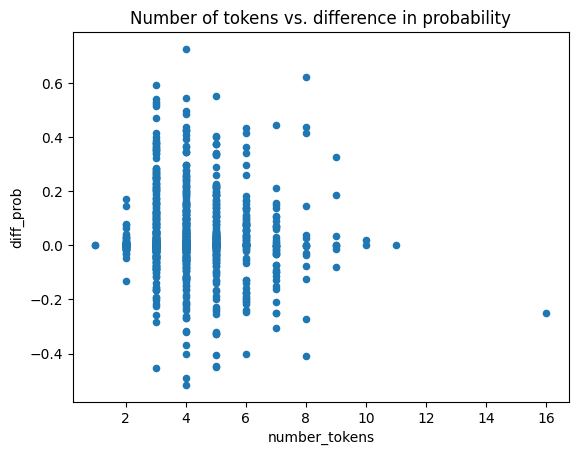

In [4]:
# Simplify dataset & add encoding
names = data.head(1000)
names = names[["name", "wiki_readers_2015_2018"]]
names["name"] = names["name"].apply(lambda x: x.replace("_", " "))
names["tokenized"] = names["name"].apply(lambda x: solu_model.tokenizer.encode(x))
names["number_tokens"] = names["tokenized"].apply(lambda x: len(x))

def correct_next_token_prob(model: EasyTransformer, tokens: List[int]) -> float:
    last_token = tokens[-1]
    logits = model("The full name of this notable person is " + model.tokenizer.decode(tokens))
    probs = torch.softmax(logits, dim=-1)
    correct_prob = probs[0][-2][last_token].item()
    return correct_prob

names["solu_prob"] = names["tokenized"].apply(
    lambda name: correct_next_token_prob(solu_model, name))
names["attn_prob"] = names["tokenized"].apply(
    lambda name: correct_next_token_prob(attn_model, name))
names["diff_prob"] = names["solu_prob"] - names["attn_prob"]

# Scatter plot number_tokens vs diff_prob
names.plot.scatter(x="number_tokens", y="diff_prob", title="Number of tokens vs. difference in probability")

In [5]:
names[names["number_tokens"] == 3]["diff_prob"].describe(), names[names["number_tokens"] == 3]["solu_prob"].describe()

(count    268.000000
 mean       0.060653
 std        0.150593
 min       -0.453002
 25%       -0.009429
 50%        0.008466
 75%        0.119991
 max        0.594531
 Name: diff_prob, dtype: float64,
 count    2.680000e+02
 mean     2.831215e-01
 std      3.151262e-01
 min      2.072000e-09
 25%      2.061605e-02
 50%      1.210382e-01
 75%      5.276176e-01
 max      9.946854e-01
 Name: solu_prob, dtype: float64)

## Direct Logit Attribution

In [90]:
model = solu_model

### Generate prompts

In [91]:
# Get the first 100 names with 3 tokens
sample_names = names[names["number_tokens"] == 3][0:99]

# Convert to 2d numpy array
sample_names_tokens = sample_names["tokenized"].tolist()
sample_names_tokens = torch.tensor(sample_names_tokens)

prompts = sample_names_tokens[:, 0:2]
answers = sample_names_tokens[:, 2]

prompts.shape, answers.shape

(torch.Size([99, 2]), torch.Size([99]))

In [92]:
# Run the model and cache all activations
original_logits, cache = model.run_with_cache(prompts)

# Logits [ prompt x token x logits]
original_logits.shape

torch.Size([99, 2, 48262])

In [93]:
prompts_second = prompts[:, 1]
bigrams = []
for second_token in prompts_second:
    bigram_logits = model(torch.tensor([second_token]))
    bigram = torch.argmax(bigram_logits, dim=-1)
    bigrams.append(bigram.squeeze().item())

bigrams = torch.tensor(bigrams)

# Check there are no bigrams that are the same as the answer
assert torch.sum(bigrams == answers).item() == 0

### Logit residual directions

TODO: Is this approach with bigrams as the negative direction sensible?

In [94]:
answer_residual_directions = model.tokens_to_residual_directions(answers)
bigram_residual_directions = model.tokens_to_residual_directions(bigrams)
logit_diff_directions = answer_residual_directions - bigram_residual_directions
logit_diff_directions.shape


torch.Size([99, 512])

### Logit Lens

In [95]:
def residual_stack_to_logit_diff(
    residual_stack: TT["components", "prompt", "d_model"], 
    cache: ActivationCache,
    logit_difference_directions: TT["prompt", "d_model"],
    prompts_list: List[str]
    ) -> TT["components"]:
    """Per component (layer) residual values -> per component logit difference

    Args:
        residual_stack: Per layer residual (e.g. the residuals right after each layer)
        cache: Cached activations from a model run
        logit_difference_directions: Logit difference directions [ prompt x d_model ]
        prompts_list: List of prompts

    Returns:
        Logit difference per layer
    """
    # Get the residual stack (after each component/layer), scaled by the
    # LayerNorm after each layer.
    scaled_residual_stack: TT["components", "prompt", "d_model"] = cache.apply_ln_to_stack(
        residual_stack, 
        layer = -1, # Layer we're taking the input to (-1 = unembed)
        pos_slice=-1 # Position we're taking the input to (-1 = final token) 
        )
    
    sum_logit_diff_per_component: TT["components"] = einsum(
        "components prompt d_model, prompt d_model -> components", 
        scaled_residual_stack, 
        logit_difference_directions
        )
    
    # Divide by number of prompts. TODO: Why????
    return sum_logit_diff_per_component/len(prompts_list)

In [97]:
# Get the (accumulated) residuals after each layer
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
print(per_layer_residual.shape)

# Get the logit difference per layer
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache, logit_diff_directions, prompts)

line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

torch.Size([4, 99, 512])


#### Logit Lens by MLP Neuron

In [99]:
# Get the (accumulated) residuals after each neuron
per_neuron_residual, labels = cache.get_full_resid_decomposition(layer=-1, pos_slice=-1, return_labels=True)
print(per_neuron_residual.shape)

# Get the logit difference per layer
per_neuron_logit_diffs = residual_stack_to_logit_diff(per_neuron_residual, cache, logit_diff_directions, prompts)

line(per_neuron_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

torch.Size([2059, 99, 512])
